<a href="https://colab.research.google.com/github/winnercalvin/Multi_Class_Classification_Example/blob/main/Multi_Class_Classification_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다중 분류 실습 - 성능 분석과 시각화

## 학습 목표
- 실전 데이터셋으로 완전한 머신러닝 파이프라인 구축
- 혼동 행렬(Confusion Matrix)을 통한 세밀한 성능 분석
- Precision, Recall, F1-Score 등 다양한 평가 지표 이해
- 모델 저장 및 불러오기
- 실전 예측 시스템 구축

## 1. 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits  # 손글씨 숫자 데이터 (0~9)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# 한글 폰트 및 그래프 스타일 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch 버전: {torch.__version__}")
print(f"NumPy 버전: {np.__version__}")

PyTorch 버전: 2.8.0+cu126
NumPy 버전: 2.0.2


## 2. 데이터 로드 및 탐색

**Digits 데이터셋**: 8x8 픽셀 손글씨 숫자 이미지 (0~9)
- 총 1,797개 샘플
- 각 샘플은 64개 특성 (8x8 픽셀)
- 10개 클래스 (0, 1, 2, ..., 9)

In [2]:
def load_and_explore_data():
    # 데이터 로드
    digits = load_digits()
    X, y = digits.data, digits.target

    print("=" * 60)
    print("데이터셋 정보")
    print("=" * 60)
    print(f"전체 샘플 수: {X.shape[0]:,}개")
    print(f"특성(Feature) 수: {X.shape[1]}개 (8x8 픽셀)")
    print(f"클래스 수: {len(np.unique(y))}개 (0~9)")
    print(f"특성값 범위: [{X.min():.1f}, {X.max():.1f}]")

    # 클래스별 분포
    print("\n클래스별 샘플 수:")
    unique, counts = np.unique(y, return_counts=True)
    for digit, count in zip(unique, counts):
        print(f"  숫자 {digit}: {count}개")

    print("=" * 60)

    return X, y, digits

# 데이터 로드
X, y, digits = load_and_explore_data()

데이터셋 정보
전체 샘플 수: 1,797개
특성(Feature) 수: 64개 (8x8 픽셀)
클래스 수: 10개 (0~9)
특성값 범위: [0.0, 16.0]

클래스별 샘플 수:
  숫자 0: 178개
  숫자 1: 182개
  숫자 2: 177개
  숫자 3: 183개
  숫자 4: 181개
  숫자 5: 182개
  숫자 6: 181개
  숫자 7: 179개
  숫자 8: 174개
  숫자 9: 180개


## 3. 샘플 이미지 시각화

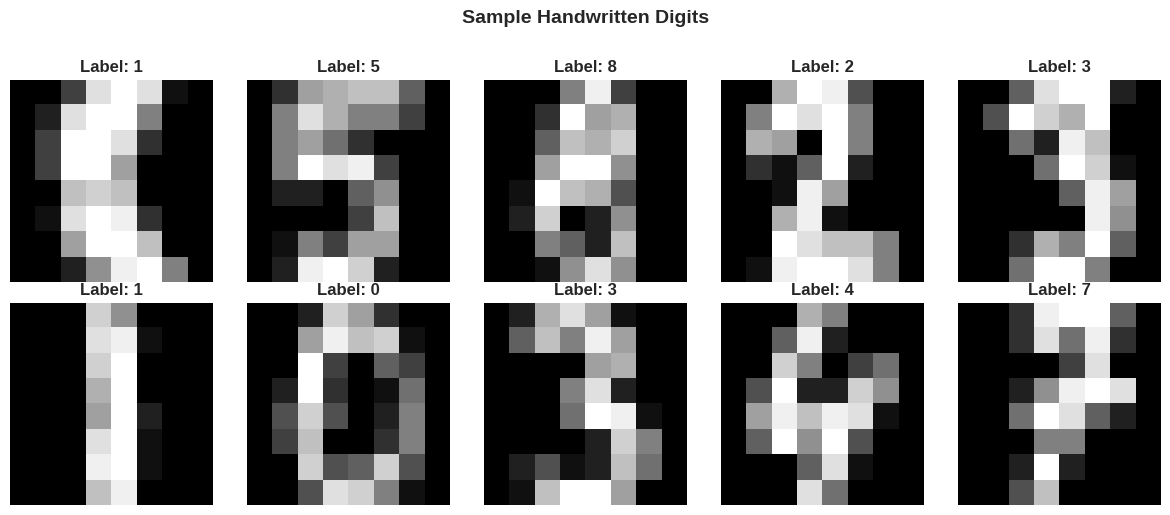

In [3]:
def visualize_samples(digits, n_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()

    # 랜덤 인덱스 선택
    random_indices = np.random.choice(len(digits.images), n_samples, replace=False)

    for idx, ax_idx in enumerate(random_indices):
        axes[idx].imshow(digits.images[ax_idx], cmap='gray')
        axes[idx].set_title(f'Label: {digits.target[ax_idx]}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('Sample Handwritten Digits', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 샘플 시각화
visualize_samples(digits)

## 4. 데이터 전처리 및 분할

In [4]:
def prepare_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    # Train+Val과 Test 분리
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train과 Validation 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )

    # 표준화 (평균=0, 표준편차=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print("\n" + "=" * 60)
    print("데이터 분할 결과")
    print("=" * 60)
    print(f"훈련 데이터: {X_train.shape[0]}개 ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"검증 데이터: {X_val.shape[0]}개 ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"테스트 데이터: {X_test.shape[0]}개 ({X_test.shape[0]/len(X)*100:.1f}%)")
    print(f"\n표준화 후 훈련 데이터 통계:")
    print(f"  평균: {X_train.mean():.4f}")
    print(f"  표준편차: {X_train.std():.4f}")
    print("=" * 60)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# 데이터 준비
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(X, y)


데이터 분할 결과
훈련 데이터: 1149개 (63.9%)
검증 데이터: 288개 (16.0%)
테스트 데이터: 360개 (20.0%)

표준화 후 훈련 데이터 통계:
  평균: -0.0000
  표준편차: 0.9763


## 5. PyTorch 텐서 변환

In [5]:
def numpy_to_tensor(X_train, X_val, X_test, y_train, y_val, y_test):
    # 입력: float32
    train_inputs = torch.FloatTensor(X_train)
    val_inputs = torch.FloatTensor(X_val)
    test_inputs = torch.FloatTensor(X_test)

    # 레이블: long (int64)
    train_labels = torch.LongTensor(y_train)
    val_labels = torch.LongTensor(y_val)
    test_labels = torch.LongTensor(y_test)

    print("\n텐서 변환 완료")
    print(f"  훈련 입력 shape: {train_inputs.shape}, dtype: {train_inputs.dtype}")
    print(f"  훈련 레이블 shape: {train_labels.shape}, dtype: {train_labels.dtype}")

    return train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels

# 텐서 변환
train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = numpy_to_tensor(
    X_train, X_val, X_test, y_train, y_val, y_test
)


텐서 변환 완료
  훈련 입력 shape: torch.Size([1149, 64]), dtype: torch.float32
  훈련 레이블 shape: torch.Size([1149]), dtype: torch.int64


## 6. 개선된 신경망 모델 정의

### 모델 특징
- **Batch Normalization**: 각 층의 출력을 정규화하여 학습 안정화
- **3-Layer Architecture**: 입력층 → 은닉층1 → 은닉층2 → 출력층
- **Dropout**: 과적합 방지

In [6]:
class AdvancedClassifier(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes, dropout_rate=0.4):
        super(AdvancedClassifier, self).__init__()

        # 첫 번째 블록
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.bn1 = nn.BatchNorm1d(hidden1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        # 두 번째 블록
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.bn2 = nn.BatchNorm1d(hidden2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # 출력층
        self.fc3 = nn.Linear(hidden2_size, num_classes)

    def forward(self, x):
        # 첫 번째 블록
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # 두 번째 블록
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # 출력층 (logits)
        logits = self.fc3(x)
        return logits

# 모델 하이퍼파라미터
input_size = train_inputs.shape[1]  # 64
hidden1_size = 128
hidden2_size = 64
num_classes = 10  # 0~9
dropout_rate = 0.5

# 모델 생성
model = AdvancedClassifier(input_size, hidden1_size, hidden2_size, num_classes, dropout_rate)

print("\n" + "=" * 60)
print("모델 구조")
print("=" * 60)
print(model)
print("=" * 60)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n총 파라미터 수: {total_params:,}")
print(f"학습 가능한 파라미터 수: {trainable_params:,}")


모델 구조
AdvancedClassifier(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

총 파라미터 수: 17,610
학습 가능한 파라미터 수: 17,610


## 7. 손실 함수 및 옵티마이저

In [7]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저: Adam
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,

)

print(f"손실 함수: {criterion}")
print(f"옵티마이저: {optimizer.__class__.__name__}")
print(f"초기 학습률: {learning_rate}")
print(f"학습률 스케줄러: ReduceLROnPlateau")

손실 함수: CrossEntropyLoss()
옵티마이저: Adam
초기 학습률: 0.001
학습률 스케줄러: ReduceLROnPlateau


## 8. 평가 함수

In [8]:
def evaluate(model, inputs, labels):
    model.eval()

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)

    return loss.item(), accuracy, predicted

## 9. 학습 루프

In [9]:
def train_with_early_stopping(model, train_inputs, train_labels, val_inputs, val_labels,
                               num_epochs=300, patience=30, print_interval=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    print("\n" + "=" * 80)
    print(f"{'Epoch':^8} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^12} | {'Val Acc':^10} | {'Status':^12}")
    print("=" * 80)

    for epoch in range(num_epochs):
        # 학습 단계
        model.train()

        outputs = model(train_inputs)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 평가 단계
        train_loss, train_acc, _ = evaluate(model, train_inputs, train_labels)
        val_loss, val_acc, _ = evaluate(model, val_inputs, val_labels)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 학습률 스케줄러 업데이트
        scheduler.step(val_loss)

        # Early Stopping 체크
        status = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            status = "✓ Best"
        else:
            epochs_no_improve += 1
            status = f"({epochs_no_improve}/{patience})"

        # 출력
        if (epoch + 1) % print_interval == 0 or epoch == 0:
            print(f"{epoch+1:^8} | {train_loss:^12.4f} | {train_acc:^10.4f} | {val_loss:^12.4f} | {val_acc:^10.4f} | {status:^12}")

        # Early Stopping
        if epochs_no_improve >= patience:
            print("=" * 80)
            print(f"Early Stopping at Epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    print("=" * 80)
    print("학습 완료!")

    # 최고 성능 모델 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"최고 성능 모델로 복원 (검증 손실: {best_val_loss:.4f})")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

# 모델 학습
history = train_with_early_stopping(
    model,
    train_inputs, train_labels,
    val_inputs, val_labels,
    num_epochs=300,
    patience=30,
    print_interval=20
)


 Epoch   |  Train Loss  | Train Acc  |   Val Loss   |  Val Acc   |    Status   
   1     |    2.3100    |   0.1201   |    2.3059    |   0.1389   |    ✓ Best   
   20    |    1.5434    |   0.8590   |    1.5407    |   0.8854   |    ✓ Best   
   40    |    0.8416    |   0.9260   |    0.8444    |   0.9271   |    ✓ Best   
   60    |    0.5016    |   0.9565   |    0.5203    |   0.9514   |    ✓ Best   
   80    |    0.3158    |   0.9756   |    0.3479    |   0.9688   |    ✓ Best   
  100    |    0.2098    |   0.9826   |    0.2514    |   0.9722   |    ✓ Best   
  120    |    0.1448    |   0.9878   |    0.1931    |   0.9722   |    ✓ Best   
  140    |    0.1040    |   0.9930   |    0.1559    |   0.9722   |    ✓ Best   
  160    |    0.0758    |   0.9956   |    0.1294    |   0.9757   |    ✓ Best   
  180    |    0.0571    |   0.9974   |    0.1144    |   0.9792   |    ✓ Best   
  200    |    0.0431    |   0.9974   |    0.0989    |   0.9792   |    ✓ Best   
  220    |    0.0331    |   0.9983   | 

## 10. 학습 과정 시각화

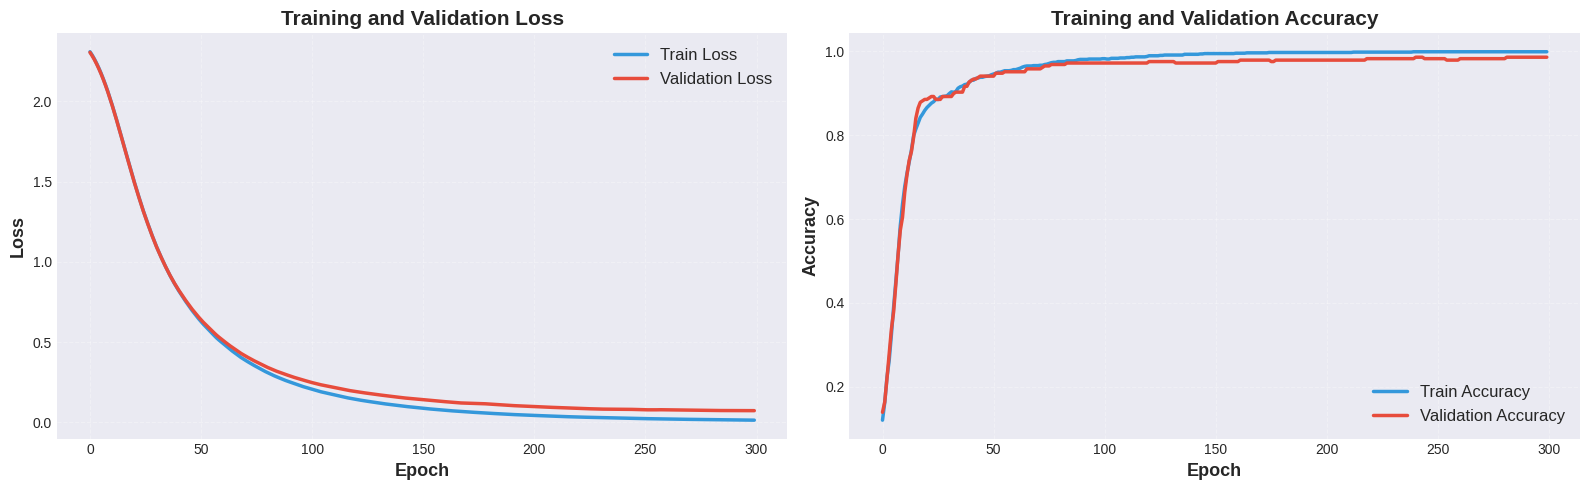

In [10]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Loss 그래프
    axes[0].plot(history['train_losses'], label='Train Loss', linewidth=2.5, color='#3498db')
    axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2.5, color='#e74c3c')
    axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=12, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle='--')

    # Accuracy 그래프
    axes[1].plot(history['train_accs'], label='Train Accuracy', linewidth=2.5, color='#3498db')
    axes[1].plot(history['val_accs'], label='Validation Accuracy', linewidth=2.5, color='#e74c3c')
    axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=12, loc='lower right')
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

# 시각화
plot_history(history)

## 11. 테스트 데이터 평가

In [11]:
# 테스트 평가
test_loss, test_acc, test_predictions = evaluate(model, test_inputs, test_labels)

print("\n" + "=" * 60)
print("최종 테스트 결과")
print("=" * 60)
print(f"테스트 손실: {test_loss:.4f}")
print(f"테스트 정확도: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 60)


최종 테스트 결과
테스트 손실: 0.0714
테스트 정확도: 0.9806 (98.06%)


:## 12. 혼동 행렬 (Confusion Matrix) 시각화

### 혼동 행렬이란?
- 각 클래스별 예측 성능을 한눈에 파악할 수 있는 표
- 행(row): 실제 레이블
- 열(column): 예측 레이블
- 대각선: 정확히 예측한 샘플 수
- 대각선 외: 잘못 예측한 샘플 수

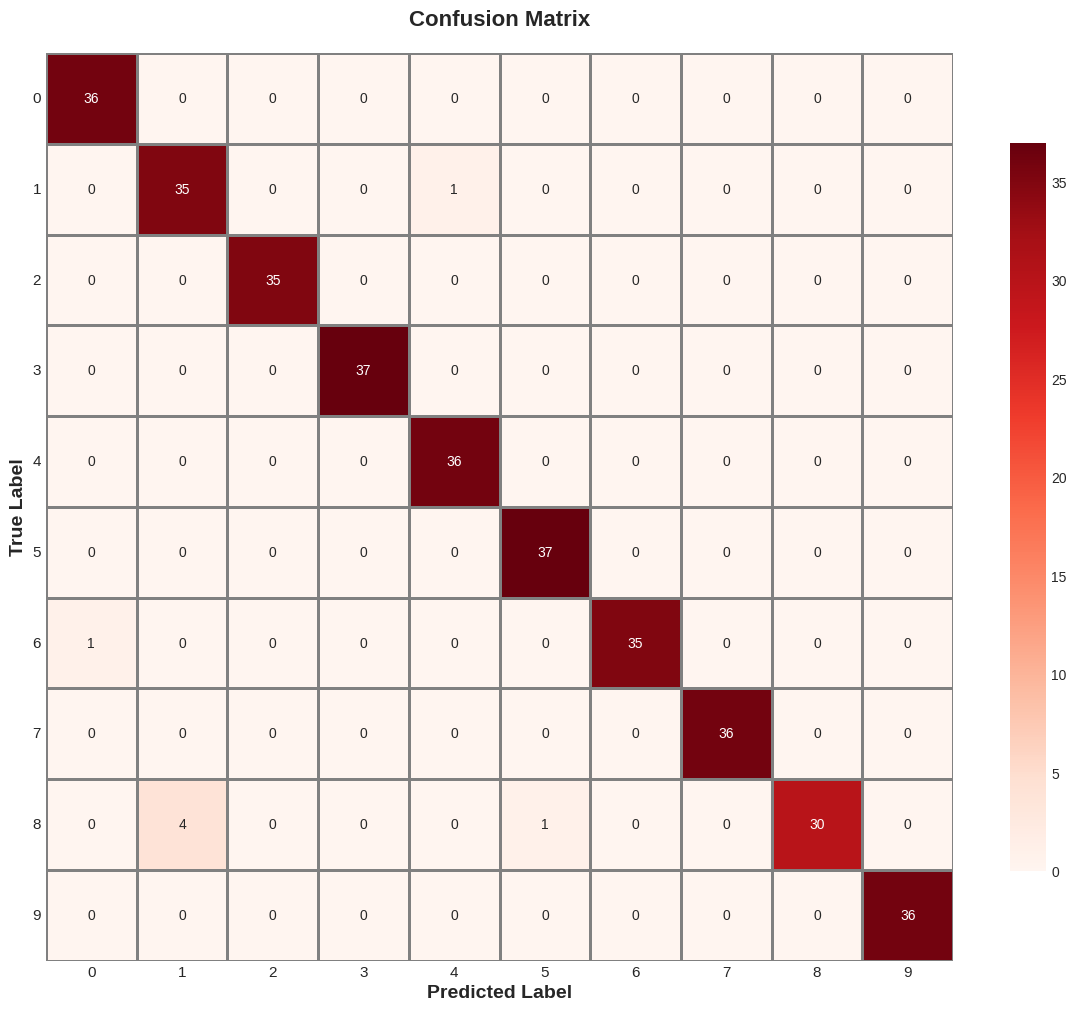


클래스별 정확도
숫자 0: 1.0000 (100.00%) - 36/36개
숫자 1: 0.9722 (97.22%) - 35/36개
숫자 2: 1.0000 (100.00%) - 35/35개
숫자 3: 1.0000 (100.00%) - 37/37개
숫자 4: 1.0000 (100.00%) - 36/36개
숫자 5: 1.0000 (100.00%) - 37/37개
숫자 6: 0.9722 (97.22%) - 35/36개
숫자 7: 1.0000 (100.00%) - 36/36개
숫자 8: 0.8571 (85.71%) - 30/35개
숫자 9: 1.0000 (100.00%) - 36/36개


In [14]:
def plot_confusion_matrix(true_labels, predicted_labels):
    # 텐서를 NumPy로 변환
    y_true = true_labels.numpy()
    y_pred = predicted_labels.numpy()

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Reds',
        square=True,
        cbar_kws={'shrink': 0.8},
        linewidths=1,
        linecolor='gray'
    )

    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)

    # 축 레이블 설정
    plt.xticks(np.arange(10) + 0.5, range(10), fontsize=11)
    plt.yticks(np.arange(10) + 0.5, range(10), fontsize=11, rotation=0)

    plt.tight_layout()
    plt.show()

    # 클래스별 정확도 출력
    print("\n" + "=" * 60)
    print("클래스별 정확도")
    print("=" * 60)
    for i in range(10):
        class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
        print(f"숫자 {i}: {class_acc:.4f} ({class_acc*100:.2f}%) - {cm[i, i]}/{cm[i].sum()}개")
    print("=" * 60)

# 혼동 행렬 시각화
plot_confusion_matrix(test_labels, test_predictions)

## 13. 상세 성능 지표 (Classification Report)

### 주요 지표 설명
- **Precision (정밀도)**: 양성으로 예측한 것 중 실제 양성의 비율
  - "이 숫자가 5라고 예측했을 때, 실제로 5일 확률"
  - Precision = TP / (TP + FP)

- **Recall (재현율)**: 실제 양성 중 양성으로 예측한 비율
  - "실제 5인 숫자 중에서 5로 올바르게 예측한 비율"
  - Recall = TP / (TP + FN)

- **F1-Score**: Precision과 Recall의 조화 평균
  - F1 = 2 × (Precision × Recall) / (Precision + Recall)

- **Support**: 각 클래스의 실제 샘플 수

In [15]:
def print_classification_report(true_labels, predicted_labels):
    y_true = true_labels.numpy()
    y_pred = predicted_labels.numpy()

    # Classification Report
    print("\n" + "=" * 70)
    print("상세 성능 보고서 (Classification Report)")
    print("=" * 70)
    print(classification_report(
        y_true,
        y_pred,
        target_names=[f'Digit {i}' for i in range(10)],
        digits=4
    ))

    # 전체 지표
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("=" * 70)
    print("전체 평균 지표 (Macro Average)")
    print("=" * 70)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 70)

# 성능 보고서 출력
print_classification_report(test_labels, test_predictions)


상세 성능 보고서 (Classification Report)
              precision    recall  f1-score   support

     Digit 0     0.9730    1.0000    0.9863        36
     Digit 1     0.8974    0.9722    0.9333        36
     Digit 2     1.0000    1.0000    1.0000        35
     Digit 3     1.0000    1.0000    1.0000        37
     Digit 4     0.9730    1.0000    0.9863        36
     Digit 5     0.9737    1.0000    0.9867        37
     Digit 6     1.0000    0.9722    0.9859        36
     Digit 7     1.0000    1.0000    1.0000        36
     Digit 8     1.0000    0.8571    0.9231        35
     Digit 9     1.0000    1.0000    1.0000        36

    accuracy                         0.9806       360
   macro avg     0.9817    0.9802    0.9802       360
weighted avg     0.9816    0.9806    0.9803       360

전체 평균 지표 (Macro Average)
Precision: 0.9817
Recall: 0.9802
F1-Score: 0.9802


## 14. 잘못 예측한 샘플 분석


총 7개의 샘플이 잘못 예측되었습니다.
오분류율: 1.94%



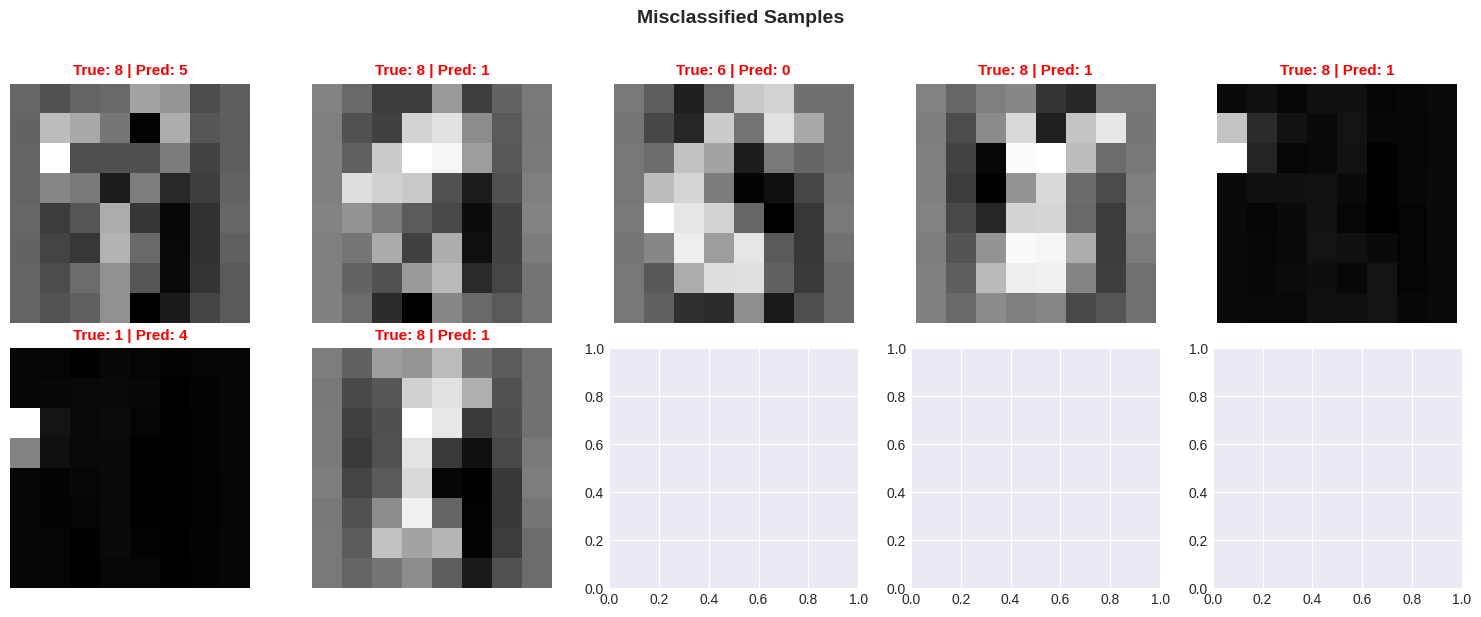

In [16]:
def analyze_misclassifications(true_labels, predicted_labels, test_data, n_samples=10):
    y_true = true_labels.numpy()
    y_pred = predicted_labels.numpy()

    # 잘못 예측한 인덱스 찾기
    misclassified_indices = np.where(y_true != y_pred)[0]

    print(f"\n총 {len(misclassified_indices)}개의 샘플이 잘못 예측되었습니다.")
    print(f"오분류율: {len(misclassified_indices)/len(y_true)*100:.2f}%\n")

    if len(misclassified_indices) == 0:
        print("완벽한 예측! 잘못 예측한 샘플이 없습니다.")
        return

    # 랜덤 샘플 선택
    sample_size = min(n_samples, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

    # 시각화
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(sample_indices):
        # 이미지 데이터 복원 (8x8)
        image = test_data[idx].reshape(8, 8)

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(
            f'True: {y_true[idx]} | Pred: {y_pred[idx]}',
            fontsize=11,
            color='red',
            fontweight='bold'
        )
        axes[i].axis('off')

    plt.suptitle('Misclassified Samples', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 오분류 샘플 분석
analyze_misclassifications(test_labels, test_predictions, X_test)

## 15. 모델 저장 및 불러오기

In [17]:
def save_model(model, filepath='digit_classifier.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': {
            'input_size': input_size,
            'hidden1_size': hidden1_size,
            'hidden2_size': hidden2_size,
            'num_classes': num_classes,
            'dropout_rate': dropout_rate
        }
    }, filepath)
    print(f"\n모델이 '{filepath}'에 저장되었습니다.")

def load_model(filepath='digit_classifier.pth'):
    """
    저장된 모델 불러오기

    Args:
        filepath: 모델 파일 경로

    Returns:
        loaded_model: 불러온 모델
    """
    checkpoint = torch.load(filepath)
    arch = checkpoint['model_architecture']

    # 모델 재생성
    loaded_model = AdvancedClassifier(
        arch['input_size'],
        arch['hidden1_size'],
        arch['hidden2_size'],
        arch['num_classes'],
        arch['dropout_rate']
    )

    # 가중치 로드
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()

    print(f"\n모델이 '{filepath}'에서 불러와졌습니다.")
    return loaded_model

# 모델 저장
save_model(model, 'digit_classifier.pth')

# 모델 불러오기 테스트
loaded_model = load_model('digit_classifier.pth')

# 불러온 모델로 테스트
test_loss_loaded, test_acc_loaded, _ = evaluate(loaded_model, test_inputs, test_labels)
print(f"\n불러온 모델의 테스트 정확도: {test_acc_loaded:.4f} ({test_acc_loaded*100:.2f}%)")


모델이 'digit_classifier.pth'에 저장되었습니다.

모델이 'digit_classifier.pth'에서 불러와졌습니다.

불러온 모델의 테스트 정확도: 0.9806 (98.06%)


## 16. 실전 예측 함수

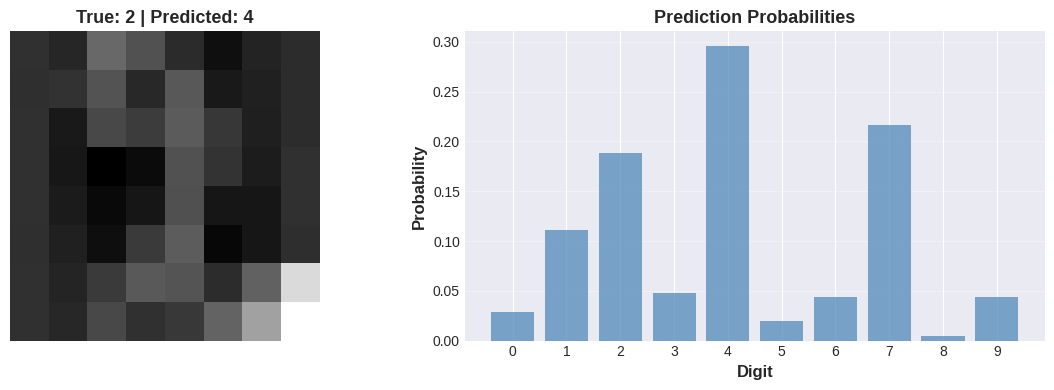


각 숫자별 예측 확률:
  숫자 0: 0.0286 (2.86%)
  숫자 1: 0.1112 (11.12%)
  숫자 2: 0.1884 (18.84%)
  숫자 3: 0.0477 (4.77%)
  숫자 4: 0.2958 (29.58%)
  숫자 5: 0.0198 (1.98%)
  숫자 6: 0.0441 (4.41%)
  숫자 7: 0.2165 (21.65%)
  숫자 8: 0.0044 (0.44%)
  숫자 9: 0.0434 (4.34%)


In [18]:
def predict_digit(model, scaler, digit_image):
    # 이미지를 1D 벡터로 변환
    digit_vector = digit_image.flatten().reshape(1, -1)

    # 표준화
    digit_scaled = scaler.transform(digit_vector)

    # 텐서 변환
    digit_tensor = torch.FloatTensor(digit_scaled)

    # 예측
    model.eval()
    with torch.no_grad():
        output = model(digit_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_digit = torch.argmax(probabilities).item()

    return predicted_digit, probabilities.numpy()

# 테스트 샘플로 예측 테스트
sample_idx = np.random.randint(0, len(X_test))
sample_image = X_test[sample_idx].reshape(8, 8)
true_digit = y_test[sample_idx]

# 예측
predicted_digit, probs = predict_digit(model, scaler, sample_image)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 이미지 표시
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f'True: {true_digit} | Predicted: {predicted_digit}',
                  fontsize=13, fontweight='bold')
axes[0].axis('off')

# 확률 분포
axes[1].bar(range(10), probs, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Digit', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Probabilities', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(10))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n각 숫자별 예측 확률:")
for i, prob in enumerate(probs):
    print(f"  숫자 {i}: {prob:.4f} ({prob*100:.2f}%)")